<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Береги-уровень-значимости-с-молоду" data-toc-modified-id="Береги-уровень-значимости-с-молоду-1">Береги уровень значимости с молоду</a></span><ul class="toc-item"><li><span><a href="#Песнь-льда-и-пламени" data-toc-modified-id="Песнь-льда-и-пламени-1.1">Песнь льда и пламени</a></span></li><li><span><a href="#Формализация-задачи:" data-toc-modified-id="Формализация-задачи:-1.2">Формализация задачи:</a></span><ul class="toc-item"><li><span><a href="#Коррекция-Бонферрони" data-toc-modified-id="Коррекция-Бонферрони-1.2.1">Коррекция Бонферрони</a></span></li><li><span><a href="#Метод-Холма" data-toc-modified-id="Метод-Холма-1.2.2">Метод Холма</a></span></li><li><span><a href="#Метод-Бенджамини-Хохберга" data-toc-modified-id="Метод-Бенджамини-Хохберга-1.2.3">Метод Бенджамини-Хохберга</a></span></li></ul></li></ul></li></ul></li></ul></div>

#  Береги уровень значимости с молоду

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from tqdm import tqdm as tqdm_botebook

plt.style.use('ggplot')

## Песнь льда и пламени

Говорят, Джордж Р.Р. Мартин, автор цикла "Песнь Льда и Пламени", истребляет Старков: чаще убивает персонажей, относящихся к этому дому, чем персонажей других домов. В таблице ниже приведено количество персонажей, относящихся к тому или иному дому, упомянутых за первые $4$ книги, а так же количество погибших персонажей.

| Дом | Упомянутые персонажи | Погибшие персонажи |
|-----|---------------------|------|
|House Stark	| 70 | 25 |
|House Lannister | 38 | 7 |
|House Greyjoy | 41 | 12 |
|Night's Watch |105 | 41 |

Нужно проверить гипотезу об этом на $5\%$ уровне значимости. 

## Формализация задачи:

Нам нужно проверить гипотезу о том, что доля смертей среди Старков совпадает со всеми остальными долями против альтернативы, что хотя бы в одной из ситуаций смертность в доме Старков больше:

\begin{equation*}
\begin{aligned} 
& H_0: p_S = p_L = p_G = p_{NW}  \\
& H_1: \text{хотя бы одна вероятность отличается}  
\end{aligned}
\end{equation*}

Протестируем все гипотезы без коррекции на множественное тестирование, а потом введём её. 

In [2]:
n_st = 70 
m_st = 25

n_lan = 38
m_lan = 7

n_gr = 41
m_gr = 12 

n_nw = 105
m_nw = 41 

alpha = 0.05

In [3]:
m_st/n_st, m_lan/n_lan, m_gr/n_gr, m_nw/n_nw

(0.35714285714285715,
 0.18421052631578946,
 0.2926829268292683,
 0.3904761904761905)

Проверяем три гипотезы!

In [4]:
from statsmodels.stats.proportion import proportions_ztest

In [5]:
help(proportions_ztest)

Help on function proportions_ztest in module statsmodels.stats.proportion:

proportions_ztest(count, nobs, value=None, alternative='two-sided', prop_var=False)
    Test for proportions based on normal (z) test
    
    Parameters
    ----------
    count : {int, array_like}
        the number of successes in nobs trials. If this is array_like, then
        the assumption is that this represents the number of successes for
        each independent sample
    nobs : {int, array_like}
        the number of trials or observations, with the same length as
        count.
    value : float, array_like or None, optional
        This is the value of the null hypothesis equal to the proportion in the
        case of a one sample test. In the case of a two-sample test, the
        null hypothesis is that prop[0] - prop[1] = value, where prop is the
        proportion in the two samples. If not provided value = 0 and the null
        is prop[0] = prop[1]
    alternative : str in ['two-sided', 'sma

In [8]:
_, p1 =  proportions_ztest((m_st, m_lan), 
                           (n_st, n_lan), 
                           value = 0, 
                           alternative = 'larger') #H0: equals


_, p2 =  proportions_ztest((m_st, m_gr), 
                           (n_st, n_gr), 
                           value = 0, 
                           alternative = 'larger')

_, p3 =  proportions_ztest((m_st, m_nw),
                           (n_st, n_nw), 
                           value = 0,
                           alternative = 'larger')

pval = np.array([p1, p2, p3])
pval

array([0.03008672, 0.24343199, 0.67209806])

In [9]:
pval > alpha # без коррекции, TRUE - не отвергается

array([False,  True,  True])

Самая первая гипотеза отвергается. Отсюда делаем вывод, что смертность значимо различается. Помним, что ошибка первого рода - ошибочный выбор альтернативы. В случае, когда мы никак не контролируем уровень значимости она оказывается завышена. Посмотрим, что будет происходить при корекции. 

### Коррекция Бонферрони

In [10]:
pval > alpha / 3  # поделили уровень значимости на число гипотез :) 

array([ True,  True,  True])

In [11]:
from statsmodels.sandbox.stats.multicomp import multipletests 

rejected, p_corrected, _, _ = multipletests(pval, 
                                            alpha = alpha, 
                                            method = 'bonferroni') 
p_corrected

array([0.09026015, 0.73029598, 1.        ])

In [13]:
# ~rejected
p_corrected > alpha # TRUE - не отвергается

array([ True,  True,  True])

Все три гипотезы о равенстве смертностей не отвергаются.

### Метод Холма

In [17]:
rejected, p_corrected, _, _ = multipletests(pval, 
                                            alpha = alpha, 
                                            method = 'holm') 
p_corrected

array([0.09026015, 0.48686399, 0.67209806])

In [18]:
p_corrected > alpha # TRUE - не отвергается

array([ True,  True,  True])

In [19]:
correction = np.arange(3,0,-1)
pval * correction

array([0.09026015, 0.48686399, 0.67209806])

In [20]:
correction

array([3, 2, 1])

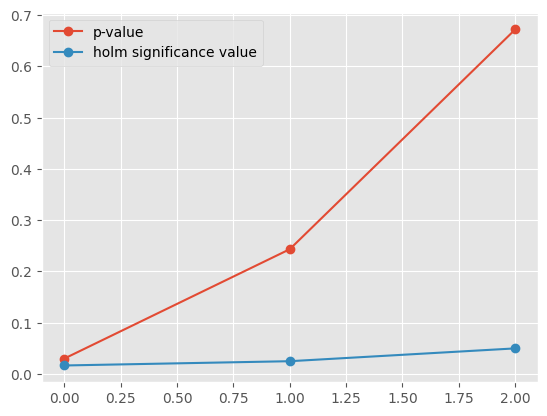

In [21]:
plt.plot(pval, 'o-',label='p-value')
plt.plot(alpha/correction, 'o-', label='holm significance value')
plt.legend()
plt.show()

Все три гипотезы о равенстве смертностей не отвергаются.

### Метод Бенджамини-Хохберга

In [22]:
rejected, p_corrected, _, _ = multipletests(pval, 
                                            alpha = alpha,
                                            method = 'fdr_bh') 
p_corrected

array([0.09026015, 0.36514799, 0.67209806])

In [23]:
pval

array([0.03008672, 0.24343199, 0.67209806])

In [24]:
p_corrected > 0.05 # TRUE - не отвергается

array([ True,  True,  True])

In [25]:
correction = np.arange(1,4,1)/3
pval / correction

array([0.09026015, 0.36514799, 0.67209806])

In [26]:
correction

array([0.33333333, 0.66666667, 1.        ])

Все три гипотезы о равенстве смертностей не отвергаются. В пакете есть и другие методы коррекции.

In [12]:
help(multipletests)

Help on function multipletests in module statsmodels.stats.multitest:

multipletests(pvals, alpha=0.05, method='hs', maxiter=1, is_sorted=False, returnsorted=False)
    Test results and p-value correction for multiple tests
    
    Parameters
    ----------
    pvals : array_like, 1-d
        uncorrected p-values.   Must be 1-dimensional.
    alpha : float
        FWER, family-wise error rate, e.g. 0.1
    method : str
        Method used for testing and adjustment of pvalues. Can be either the
        full name or initial letters. Available methods are:
    
        - `bonferroni` : one-step correction
        - `sidak` : one-step correction
        - `holm-sidak` : step down method using Sidak adjustments
        - `holm` : step-down method using Bonferroni adjustments
        - `simes-hochberg` : step-up method  (independent)
        - `hommel` : closed method based on Simes tests (non-negative)
        - `fdr_bh` : Benjamini/Hochberg  (non-negative)
        - `fdr_by` : Benjamini/

https://xkcd.com/882/

![](https://imgs.xkcd.com/comics/significant.png)

## Пример с лекции про кнопки и котиков

In [27]:
from matplotlib import pylab as plt
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [28]:
# средние значение двух распределений
mu_c = 0.1
mu_t = 0.6

# дисперсии двух распределений
s_c = 0.25
s_t = 0.3

# порог: наблюдая значение исследуемой величины выше этого порога,
# мы относим ее к синему распределению
c = 1.3*(mu_c + mu_t)/2

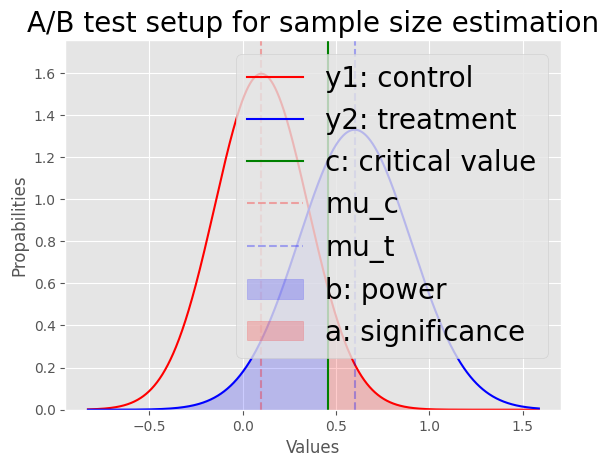

In [29]:
support = np.linspace(
    stats.norm.ppf(0.0001, loc=mu_c, scale=s_c), 
    stats.norm.ppf(1 - 0.0005, loc=mu_t, scale=s_t), 1000)
y1 = stats.norm.pdf(support, loc=mu_c, scale=s_c)
y2 = stats.norm.pdf(support, loc=mu_t, scale=s_t)

fig, ax = plt.subplots()
ax.plot(support, y1, color='r', label='y1: control')
ax.plot(support, y2, color='b', label='y2: treatment')
ax.set_ylim(0, 1.1*np.max([
            stats.norm.pdf(mu_c, loc=mu_c, scale=s_c),
            stats.norm.pdf(mu_t, loc=mu_t, scale=s_t)
        ]))
ax.axvline(c, color='g', label='c: critical value')
ax.axvline(mu_c, color='r', alpha=0.3, linestyle='--', label='mu_c')
ax.axvline(mu_t, color='b', alpha=0.3, linestyle='--', label='mu_t')
ax.fill_between(support[support <= c], 
                y2[support <= c], 
                color='b', alpha=0.2, label='b: power')
ax.fill_between(support[support >= c], 
                y1[support >= c], 
                color='r', alpha=0.2, label='a: significance')

ax.legend(loc='upper right', prop={'size': 20})
ax.set_title('A/B test setup for sample size estimation', fontsize = 20)
ax.set_xlabel('Values')
ax.set_ylabel('Propabilities')

plt.show()

In [30]:
def get_size(theta_c, theta_t, alpha, beta):
    # вычисляем квантили нормального распределения
    t_alpha = stats.norm.ppf(1 - alpha, loc=0, scale=1)
    t_beta = stats.norm.ppf(beta, loc=0, scale=1)
    # решаем уравнение относительно n
    n = t_alpha * np.sqrt(theta_t * (1 - theta_t))
    n -= t_beta*np.sqrt(theta_c*(1 - theta_c))
    n /= theta_c - theta_t
    return int(np.ceil(n*n))

In [32]:
n_max = get_size(0.001, 0.0011, 0.01, 0.2)
print(n_max)

1075678


In [33]:
# выводим порог, выше которого отклоняется H_0
print(0.001 + stats.norm.ppf(1 - 0.01, loc=0, scale=1)*np.sqrt(0.001*(1 - 0.001)/n_max))

0.0010708951064660392


# Еще примеры имплементации поправок на множественную проверку гипотез

In [34]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import requests, time
import seaborn as sns

from datetime import datetime, timedelta
from io import StringIO
from scipy import stats
from tqdm import tqdm
from statsmodels.stats.weightstats import ztest as ztest
from statsmodels.sandbox.stats.multicomp import multipletests
from statsmodels.stats.power import TTestIndPower
from typing import List

In [35]:
import warnings
warnings.filterwarnings('ignore')

# Simulation of a standard experiment with two groups

In [36]:
help(stats.ttest_ind)

Help on function ttest_ind in module scipy.stats._stats_py:

ttest_ind(a, b, axis=0, equal_var=True, nan_policy='propagate', permutations=None, random_state=None, alternative='two-sided', trim=0)
    Calculate the T-test for the means of *two independent* samples of scores.
    
    This is a test for the null hypothesis that 2 independent samples
    have identical average (expected) values. This test assumes that the
    populations have identical variances by default.
    
    Parameters
    ----------
    a, b : array_like
        The arrays must have the same shape, except in the dimension
        corresponding to `axis` (the first, by default).
    axis : int or None, optional
        Axis along which to compute test. If None, compute over the whole
        arrays, `a`, and `b`.
    equal_var : bool, optional
        If True (default), perform a standard independent 2 sample test
        that assumes equal population variances [1]_.
        If False, perform Welch's t-test, which

In [39]:
pvalues_list = list()
alpha = 0.05
mu = 5
std = 1
group_size = 200
np.random.seed(42)

for _ in tqdm(range(1000)) :
    p_values = list()
    control = np.random.normal(mu, std, group_size)
    treatment = np.random.normal(mu, std, group_size)
    
    pvalue = stats.ttest_ind(control, treatment)[1] # here the probability of a type I error = 0.05
    
    if pvalue < alpha :
        pvalues_list.append(1)
    else:
        pvalues_list.append(0)

print(f"Ошибка I рода: {np.mean(pvalues_list)}")

100%|████████████████████████████████████| 1000/1000 [00:00<00:00, 13408.21it/s]

Ошибка I рода: 0.045


The Type I error is ~0.05 as expected

In [40]:
pvalues_list = list()
alpha = 0.05
mu = 5
std = 1
group_size = 200
np.random.seed(42)

for _ in tqdm(range(1000)):
    p_values = list()
    control = np.random.normal(mu, std, group_size)
    treatment1 = np.random.normal(mu, std, group_size)
    treatment2 = np.random.normal(mu, std, group_size)
    
    pvalue_a = stats.ttest_ind(control, treatment1)[1] # here the probability of a type I error = 0.05
    pvalue_b = stats.ttest_ind(control, treatment2)[1] # here the probability of a type I error = 0.05
    pvalue_c = stats.ttest_ind(treatment1, treatment2)[1] # and here the probability of a type I error = 0.05
    
    # in total, the probability of being wrong in at least one of the cases = 1 - P(we will never make a mistake) = 1 - (0.95 ** 3) ~= 0.14
    
    if pvalue_a < 0.05 or pvalue_b < 0.05 or pvalue_c < 0.05:
        pvalues_list.append(1)
    else:
        pvalues_list.append(0)

print(f"Групповая вероятность ошибки I рода: {np.mean(pvalues_list)}")

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 5124.34it/s]

Групповая вероятность ошибки I рода: 0.131


Type I error is much greater than 0.05

## Change in FWER depending on the number of comparisons

In [41]:
n_list = np.arange(1, 100)

result = {}

for n in n_list:
    result[n] = 1 - (1 - 0.05) ** n

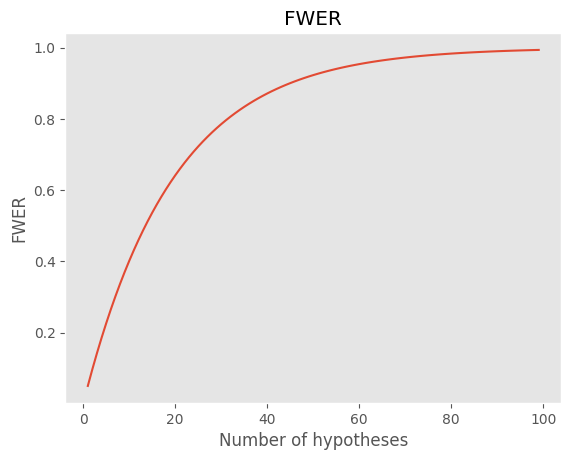

In [42]:
plt.plot(list(result.keys()), list(result.values()))
plt.title("FWER")
plt.xlabel("Number of hypotheses")
plt.ylabel("FWER")
plt.grid()
plt.show()

### Functions for correction methods that will be useful later

In [43]:
def method_without_correct(p_values: List[float], alpha: float = 0.05):
    """The function returns the comparison result without corrections"""
    
    res = (np.array(p_values) <= alpha).astype(int)
    return res

In [44]:
def method_bonferroni(p_values: List[float], alpha: float = 0.05):
    """The function returns the comparison result with Bonferroni correction"""
    
    return (multipletests(p_values, alpha = alpha, method = "bonferroni")[0]).astype(int)


In [45]:
def method_holm(p_values: List[float], alpha: float = 0.05):
    """The function returns the comparison result with Holm correction"""
    
    return (multipletests(p_values, alpha=alpha, method = "holm")[0]).astype(int)

In [46]:
def method_benjamini_hochberg(p_values: List[float], alpha: float = 0.05):
    """The function returns the comparison result with Benjamini-Hochberg correction"""
    
    return (multipletests(p_values, alpha=alpha, method="fdr_bh")[0]).astype(int)

### Functions for demonstrating graphs with the behavior of the methods in question

In [47]:
def draw_plot(methods: List[str], num_of_tests: List[int], metric: str, result: dict, title: str) -> None:
    """Visualization of a plot of errors depending on the number of comparisons"""
    
    sns.set(style = "darkgrid")
    fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=200)
    
    method_markup = dict()
    
    for method in methods:
        if method == "without_correct":
            method_markup[method] = ["-v"]
        elif method == "bonferroni":
            method_markup[method] = ["-o"]
        elif method == "holm":
            method_markup[method] = ["-o"]
        else:
            method_markup[method] = ["->"]
    
    if metric in ("fwer", "fdr"):
        ax.hlines(alpha, 0, max(num_of_tests), linestyles='--', label=f"alpha={alpha}", color="red")
    else:
        ax.hlines(0.2, 0, max(num_of_tests), linestyles='--', label="beta=0.2", color='r')
    
    for method, value in result.items():
        ax.plot(value.keys(), value.values(), method_markup[method][0], label = method, alpha = 0.7)
        ax.legend(fontsize=12)
        ax.set_title(title)
        ax.set_xlabel("Experiments, num")
        ax.set_ylabel(title)
    
    return


In [48]:
def get_errors(result: dict, metric: str, methods: list, num_of_tests: list, no_effect_type: int) -> dict:
    """Function for calculating errors"""
    
    errors_dict = {
        method_name: {
            num: []
            for num in num_of_tests
        }
        for method_name in methods
    }

    for method, params in result.items():
        if metric == "fdr":
            for cnt, val in params.items():
                if no_effect_type == -1:
                    cnt_groups_no_effects = 1
                elif no_effect_type == 0:
                    cnt_groups_no_effects = cnt // 2
                else:
                    cnt_groups_no_effects = cnt - 1
                fp = np.array(val["first"]) * (cnt - cnt_groups_no_effects)
                tp = (1 - np.array(val["second"])) * cnt
                fp_tp = fp + tp
                fp_tp[fp_tp < 1] = 1
                errors_dict[method][cnt] = np.mean(fp / fp_tp)
        elif metric == "fwer":
            for cnt, val in params.items():
                errors_dict[method][cnt] = np.mean(np.array(val["first"]) > 0)
        elif metric == "error_type_II":
            for cnt, val in params.items():
                errors_dict[method][cnt] = np.mean(val["second"])
        else:
            for cnt, val in params.items():
                errors_dict[method][cnt] = np.mean(np.array(val["second"]) > 0)

    return errors_dict


In [49]:
def construct_groups(num: int, cnt_groups_no_effects: int, metric: str, 
                     mu: float, std: float, group_size: str, effect: float) -> list:
    """Function for forming groups"""
    
    groups_list = list()
    
    for _ in range(num):
        if metric == "fwer":
            groups_list.append((np.random.normal(mu, std, group_size), np.random.normal(mu, std, group_size)))
        elif metric in ("fwer II", "error_type_II"):
            groups_list.append((np.random.normal(mu, std, group_size),
                    np.random.normal(mu * (1 + effect), std, group_size)
                )
            )
        else:
            for _ in range(cnt_groups_no_effects):
                groups_list.append((np.random.normal(mu, std, group_size), np.random.normal(mu, std, group_size)))

            for _ in range(num - cnt_groups_no_effects):
                groups_list.append((np.random.normal(mu, std, group_size),
                        np.random.normal(mu * (1 + effect), std, group_size)
                    )
                )
    return groups_list

In [50]:
def get_plot_metrics(methods: list, num_of_tests: list, metric: str, 
                     title: str, group_size: int = 100, effect: float = 0.0,
    mu: float = 5.0, std: float = 1, n_iter: int = 300, alpha: float = 0.05, no_effect_type: int = 0) -> None:
    """"""
    if metric not in ("fwer", "fwer II", "fdr", "error_type_II"):
        return "Incorrect Method Name"
    
    result = {
        method: {num: {"first": [], "second": []} for num in num_of_tests} for method in methods
    }
    
    
    for num in tqdm(num_of_tests):
        cnt_groups_no_effects = 0
        if metric == "fdr":
            if no_effect_type == -1:
                cnt_groups_no_effects = 1
            elif no_effect_type == 0:
                cnt_groups_no_effects = num // 2
            else:
                cnt_groups_no_effects = num - 1
        
        for _ in range(n_iter):
            groups_list = construct_groups(num, cnt_groups_no_effects, metric, mu, std, group_size, effect)

            p_values = list()
    
            for control, treatment in groups_list:
                p_values.append(stats.ttest_ind(control, treatment)[1])

            for method in methods:
                if method == "without_correct":
                    func = method_without_correct
                elif method == "bonferroni":
                    func = method_bonferroni
                elif method == "holm":
                    func = method_holm
                else:
                    func = method_benjamini_hochberg
                
                if metric in ("fwer", "fwer II", "error_type_II"):
                    result[method][num]["first"].append(np.mean(func(p_values)))
                    result[method][num]["second"].append(
                        1 - np.mean(func(p_values))
                    )
                else:
                    result[method][num]["first"].append(np.mean(func(p_values)[:cnt_groups_no_effects]))
                    result[method][num]["second"].append(
                        1 - np.mean(func(p_values)[cnt_groups_no_effects:])
                    )

    errors = get_errors(result, metric, methods, num_of_tests, no_effect_type)
    
    draw_plot(methods, num_of_tests, metric, errors, title)

    return 


List of methods that will be passed to the function for drawing a graph

In [51]:
methods = [
    "without_correct",
    "bonferroni",
    "holm",
    "benjamini-hochberg"
]

Drawing a graph showing the behavior of the methods in question depending on the specified parameters

## FWER

### Bonferroni

#### Checking FWER control using the Bonferroni method

In [52]:
methods = [
    "without_correct",
    "bonferroni",
#     "holm",
#     "benjamini-hochberg"
]

In [53]:
power_analysis = TTestIndPower()

effect_size = power_analysis.solve_power(
    power = 0.8, 
    alpha = 0.05,
    nobs1 = 100,
    alternative = "two-sided"
)

print(f"Effect size (MDE) to add to test group: {round(effect_size, 3)}")

Effect size (MDE) to add to test group: 0.398


In [54]:
help(power_analysis.solve_power)

Help on method solve_power in module statsmodels.stats.power:

solve_power(effect_size=None, nobs1=None, alpha=None, power=None, ratio=1.0, alternative='two-sided') method of statsmodels.stats.power.TTestIndPower instance
    solve for any one parameter of the power of a two sample t-test
    
    for t-test the keywords are:
        effect_size, nobs1, alpha, power, ratio
    
    exactly one needs to be ``None``, all others need numeric values
    
    Parameters
    ----------
    effect_size : float
        standardized effect size, difference between the two means divided
        by the standard deviation. `effect_size` has to be positive.
    nobs1 : int or float
        number of observations of sample 1. The number of observations of
        sample two is ratio times the size of sample 1,
        i.e. ``nobs2 = nobs1 * ratio``
    alpha : float in interval (0,1)
        significance level, e.g. 0.05, is the probability of a type I
        error, that is wrong rejections if the 

In [55]:
num_of_tests = [1, 2, 3, 5, 10, 30, 50]

100%|█████████████████████████████████████████████| 7/7 [00:03<00:00,  2.13it/s]


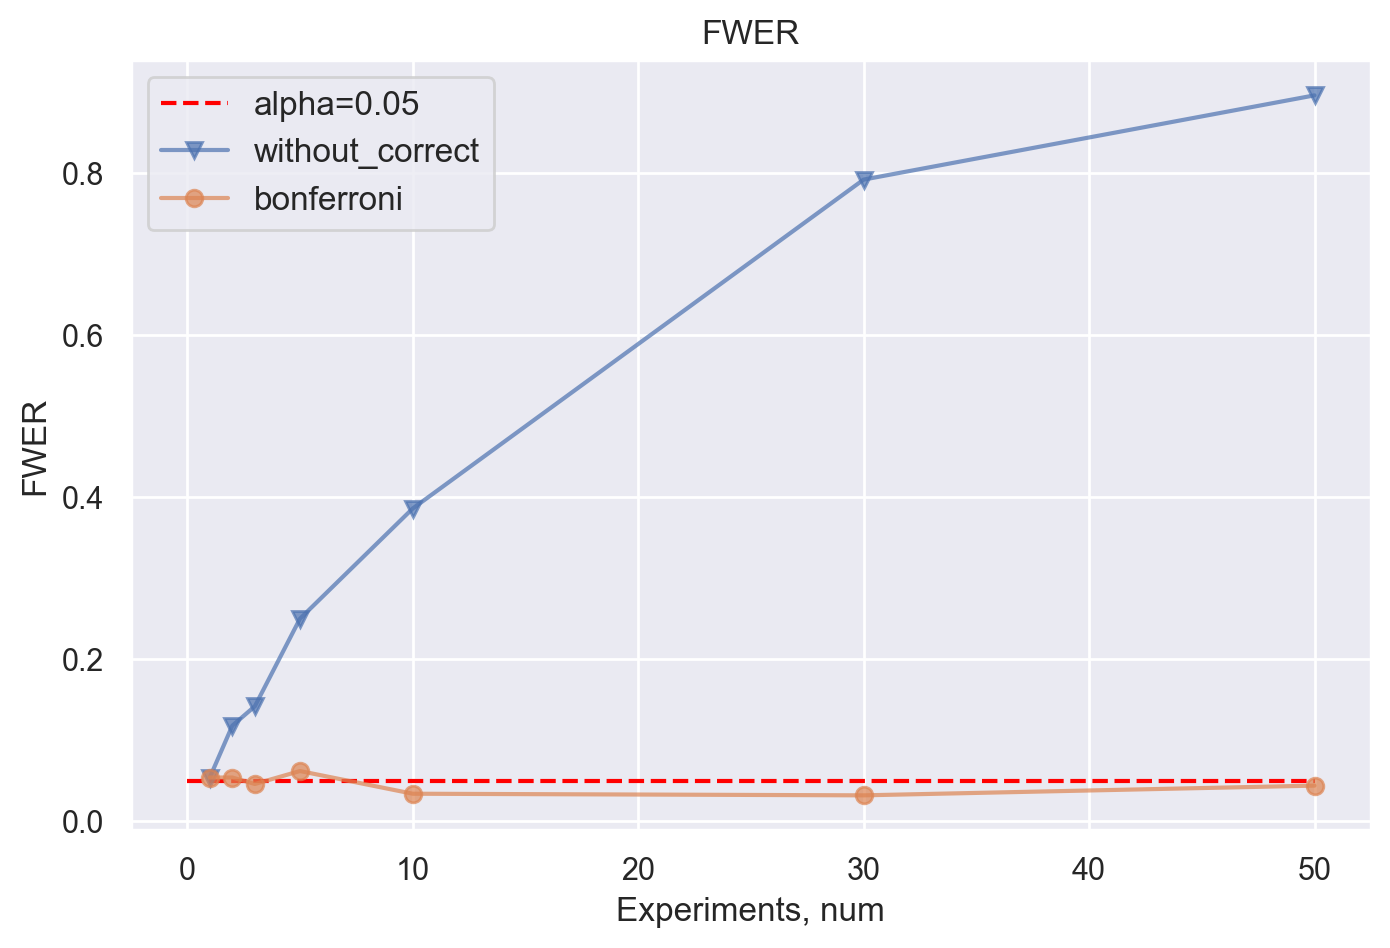

In [56]:
get_plot_metrics(
    methods, # list of methods for comparing
    num_of_tests, # list of number of comparings
    "fwer", # type error for drawing
    "FWER", # title and ylabel for plot
    group_size = 100,
    effect = 0.0,
    mu = 5.0,
    std = 1,
    n_iter = 500,
    alpha = 0.05
)

#### Checking FWER II control using the Bonferroni method

100%|█████████████████████████████████████████████| 7/7 [00:07<00:00,  1.11s/it]


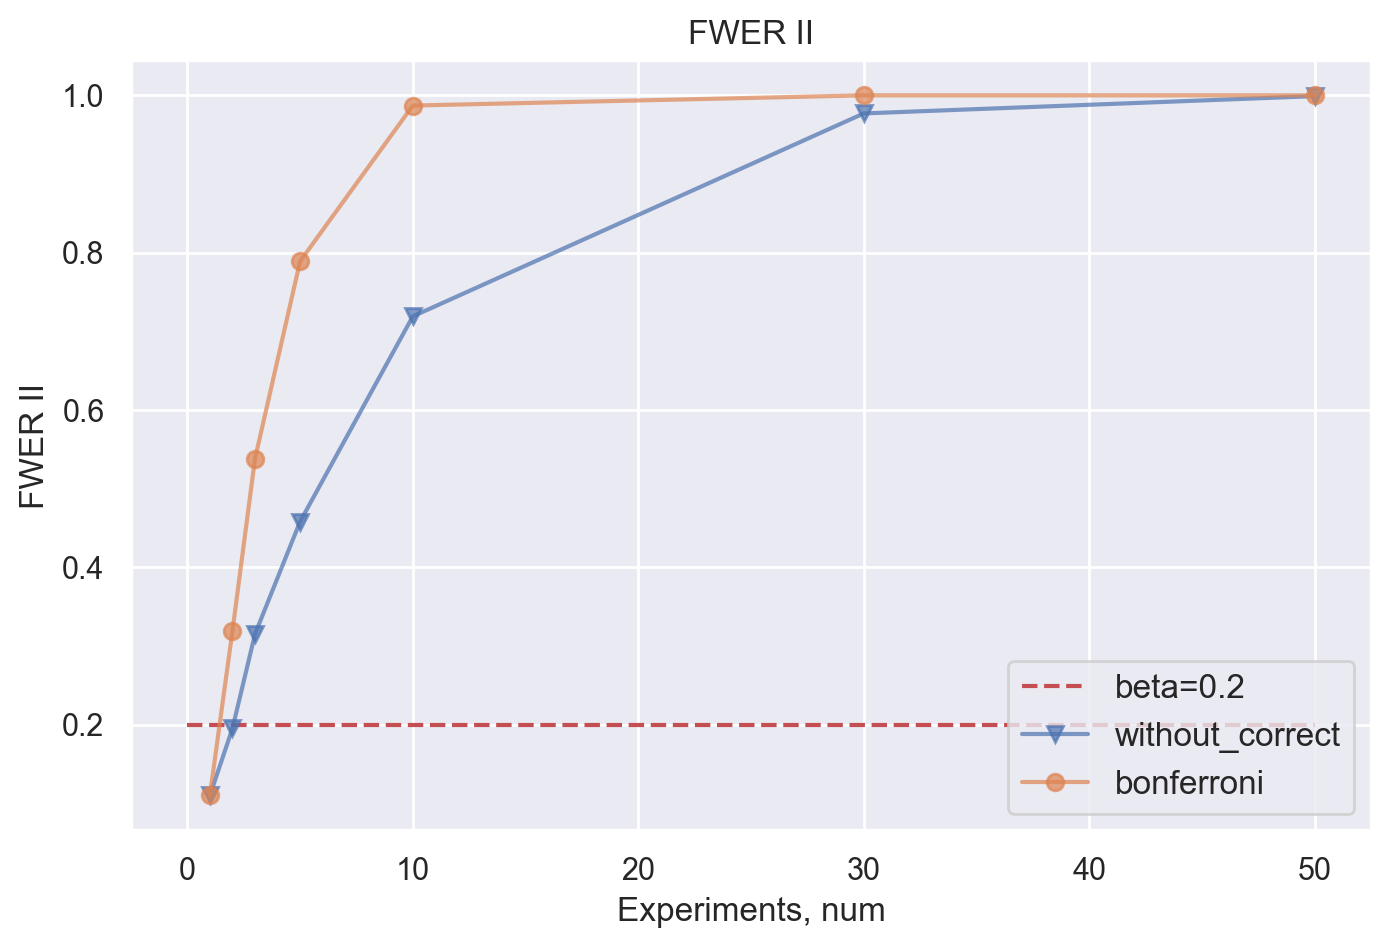

In [57]:
get_plot_metrics(
    methods,
    num_of_tests,
    "fwer II",
    "FWER II",
    group_size = 500, # Added a larger sample size to make the graph more readable
    effect = 0.0398, # mde
    mu = 5,
    std = 1,
    n_iter = 1000,
    alpha = 0.05
)

## Holm

### Checking FWER control using the Holm method

In [58]:
methods = [
    "without_correct",
    "bonferroni",
    "holm",
#     "benjamini-hochberg"
]

100%|█████████████████████████████████████████████| 7/7 [04:37<00:00, 39.69s/it]


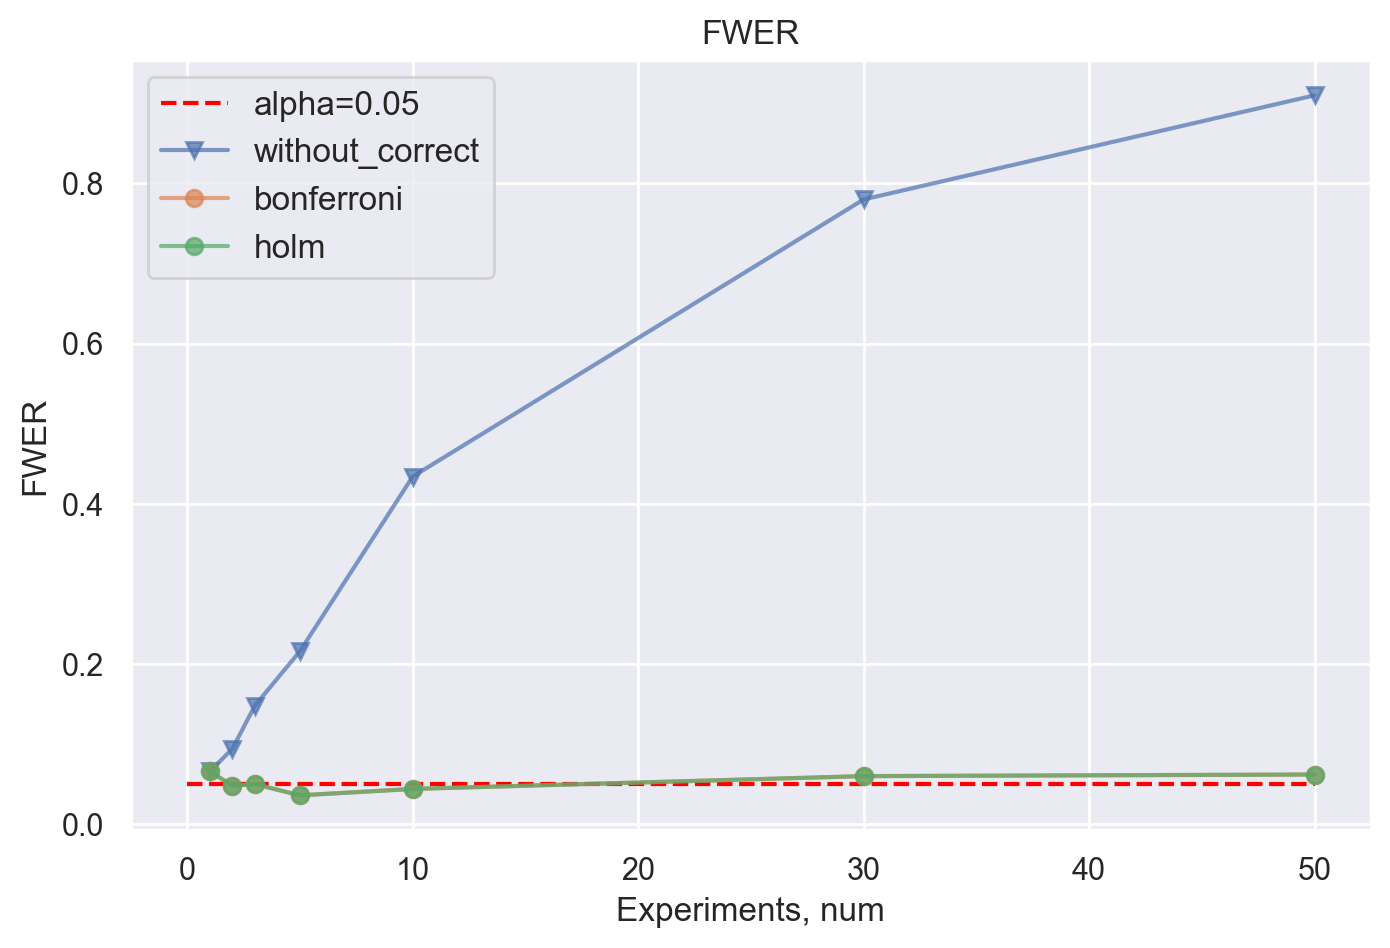

In [59]:
get_plot_metrics(
    methods,
    num_of_tests,
    "fwer",
    "FWER",
    group_size = 100,
    effect = 0.0,
    mu = 5,
    std = 1,
    n_iter = 500,
    alpha = 0.05,
)

### Checking FWER II control using the Holm method

100%|█████████████████████████████████████████████| 7/7 [04:41<00:00, 40.27s/it]


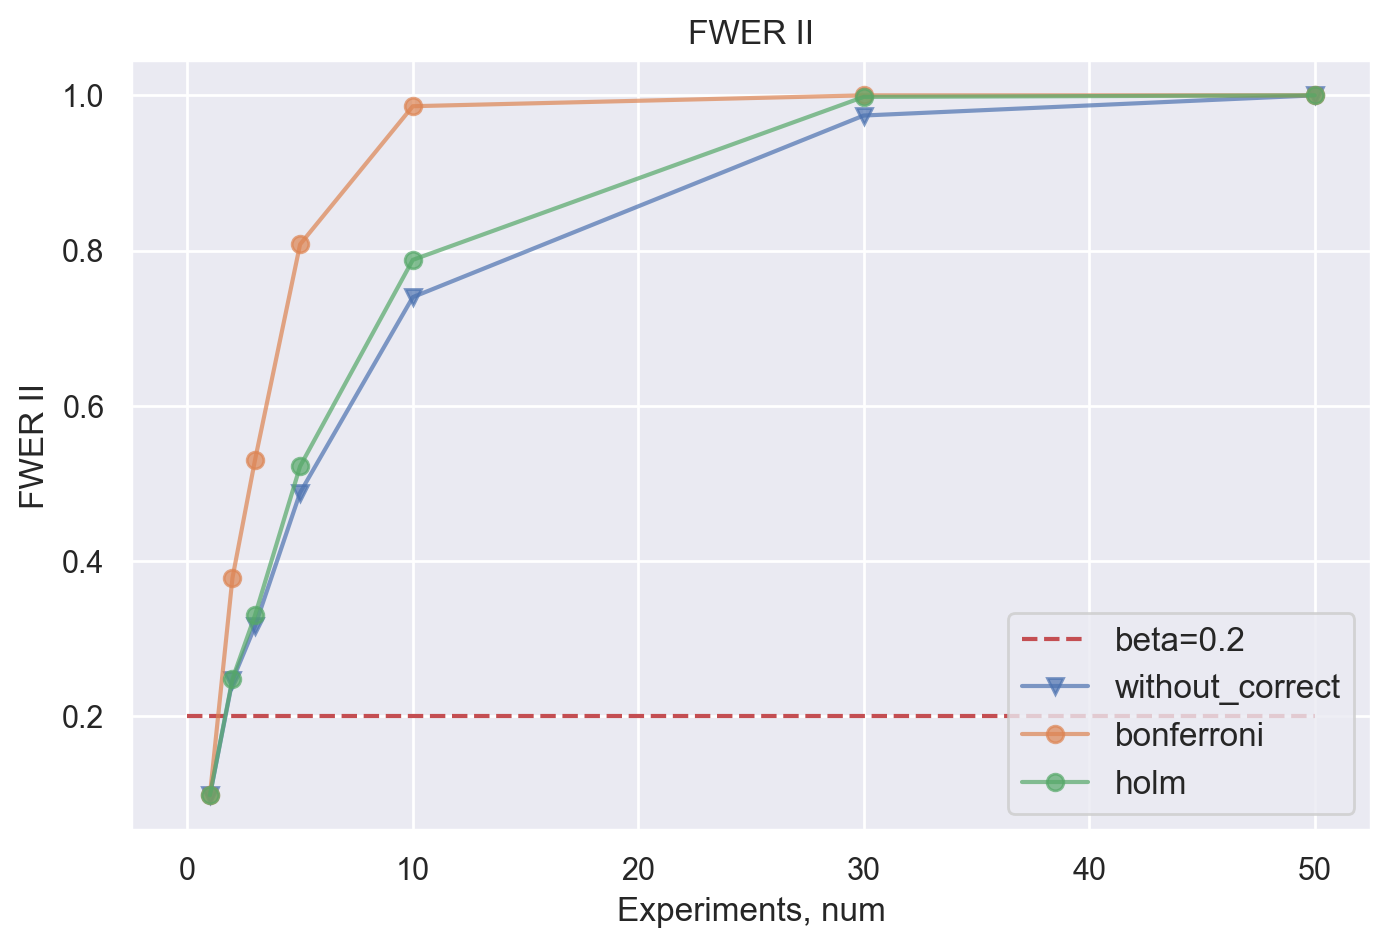

In [60]:
get_plot_metrics(
    methods,
    num_of_tests,
    "fwer II",
    "FWER II",
    group_size=500,
    effect=0.0398,
    mu=5,
    std=1,
    n_iter=500,
    alpha=0.05
)

## FDR

In [61]:
methods = [
    "without_correct",
    "bonferroni",
    "holm",
    "benjamini-hochberg"
]

### Checking FDR control using the B-H method

Half of the hypotheses have an effect, half have no effect

100%|█████████████████████████████████████████████| 7/7 [06:00<00:00, 51.49s/it]


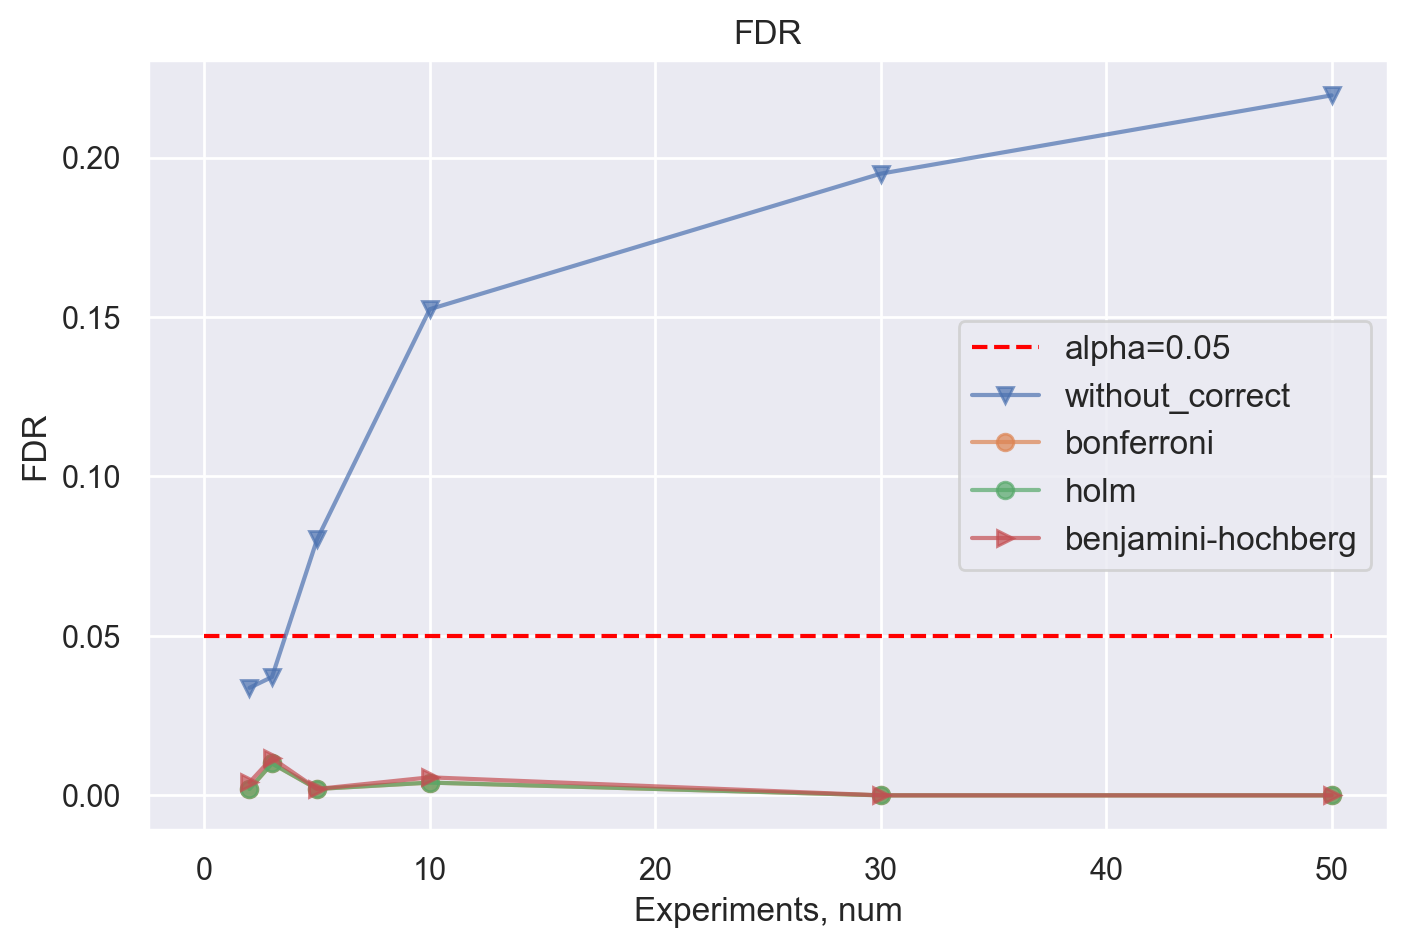

In [62]:
get_plot_metrics(
    methods,
    num_of_tests,
    "fdr",
    "FDR",
    group_size=20,
    effect=0.0398,
    mu=5,
    std=1,
    n_iter=500,
    alpha=0.05,
    no_effect_type=0
)

One hypothesis from all without effect, the rest - with effect

100%|█████████████████████████████████████████████| 7/7 [05:38<00:00, 48.41s/it]


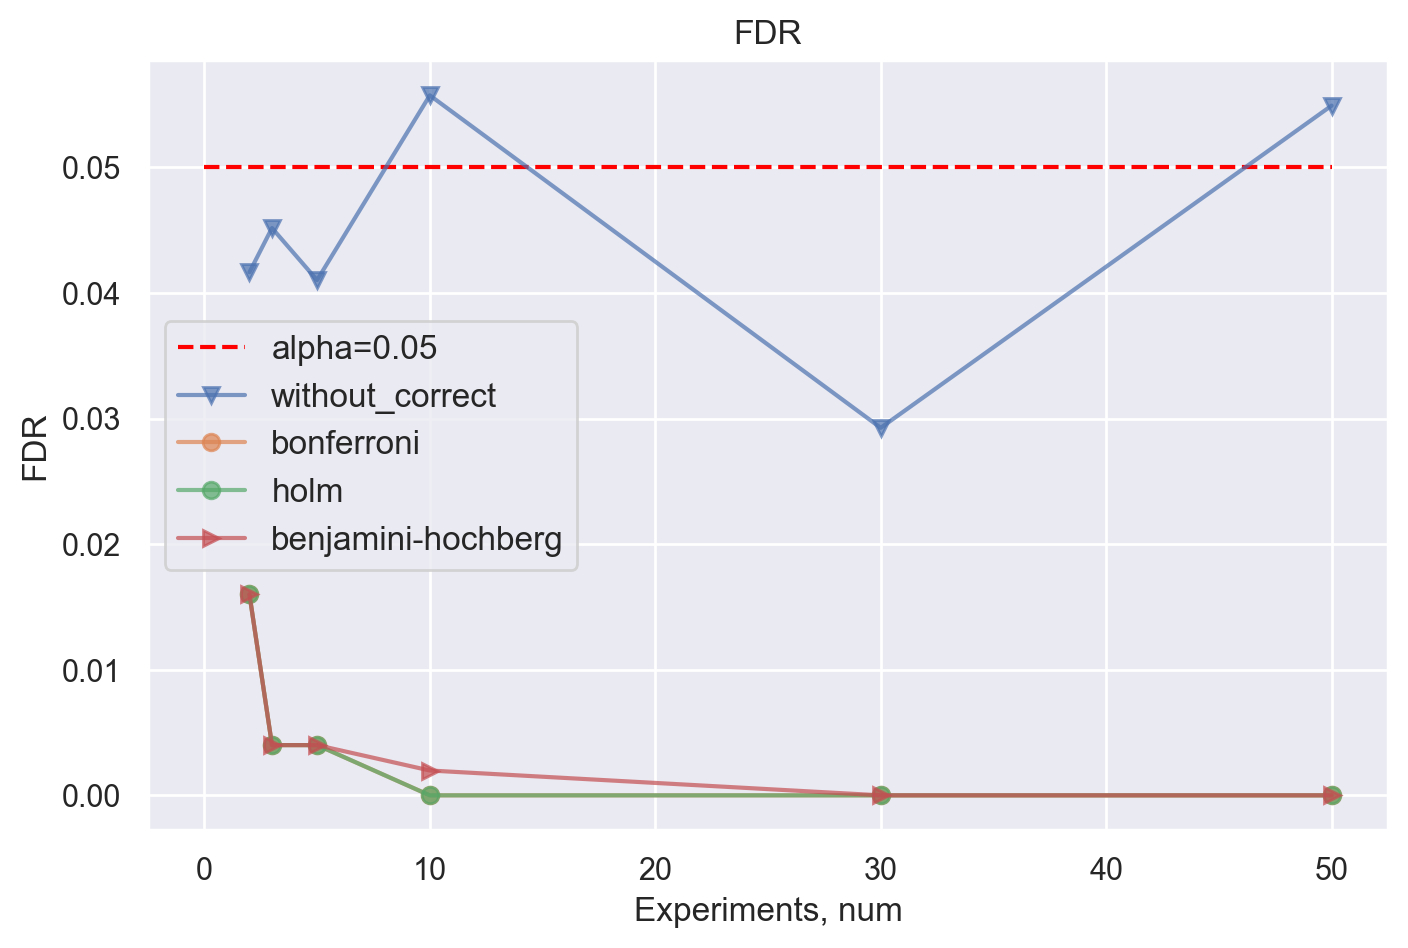

In [63]:
get_plot_metrics(
    methods,
    num_of_tests,
    "fdr",
    "FDR",
    group_size=20,
    effect=0.0398,
    mu=5,
    std=1,
    n_iter=500,
    alpha=0.05,
    no_effect_type=-1
)

One of all hypotheses has an effect, the rest have no effect

100%|█████████████████████████████████████████████| 7/7 [05:42<00:00, 48.89s/it]


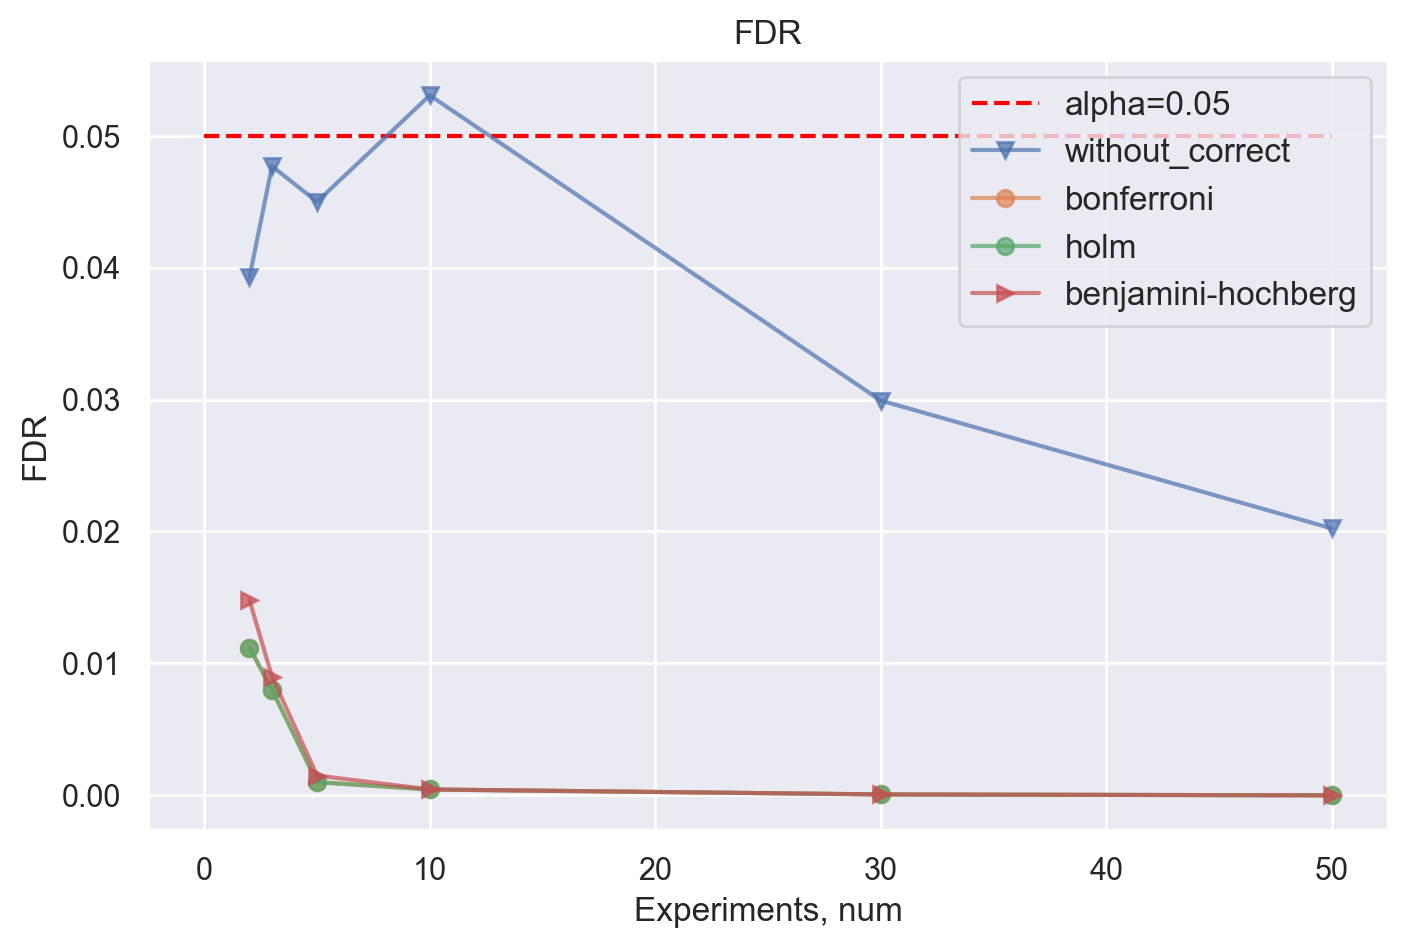

In [64]:
get_plot_metrics(
    methods,
    num_of_tests,
    "fdr",
    "FDR",
    group_size=20,
    effect=0.0398,
    mu=5,
    std=1,
    n_iter=500,
    alpha=0.05,
    no_effect_type=1
)